In [ ]:
!pip install -U --pre tensorflow=="2.*"
!pip install tf_slim

In [ ]:
!pip install pycocotools

In [28]:
import os
import pathlib


if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Clonage dans 'models'...
remote: Enumerating objects: 3254, done.
remote: Counting objects: 100% (3254/3254), done.
remote: Compressing objects: 100% (2565/2565), done.
remote: Total 3254 (delta 881), reused 1533 (delta 641), pack-reused 0
Réception d'objets: 100% (3254/3254), 33.45 Mio | 3.12 Mio/s, fait.
Résolution des deltas: 100% (881/881), fait.


In [29]:
%%bash
cd models/research/
ls
protoc object_detection/protos/*.proto --python_out=.

adversarial_text
attention_ocr
audioset
autoaugment
cognitive_planning
cvt_text
deeplab
deep_speech
delf
efficient-hrl
lfads
lstm_object_detection
marco
nst_blogpost
object_detection
pcl_rl
README.md
rebar
seq_flow_lite
slim
vid2depth


In [30]:
%%bash 
cd models/research
cp object_detection/packages/tf2/setup.py .
pip install .

Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple
Processing /home/julien/Bureau/M2/PFE/TensorFlow/models/research


  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1686665 sha256=c4f1d3b799a008dbd0307cc3ec6a461ab71d0103a3c8b3075a75f40d991b3579
  Stored in directory: /tmp/pip-ephem-wheel-cache-txgna2po/wheels/de/8b/2d/0fc45ee1d65a1dfbb66efb78d4a782a2a2b7adb10932761bb1
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


You should consider upgrading via the '/home/julien/anaconda3/bin/python -m pip install --upgrade pip' command.


In [31]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [32]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))

  return model

In [33]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [34]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[PosixPath('test_images/1478019974679051391_jpg.rf.7XNGCef6norKALU4vpMn.jpg'),
 PosixPath('test_images/1478019975180844551_jpg.rf.067fd6f8346d62a38da50548d06554f6.jpg'),
 PosixPath('test_images/1478019975180844551_jpg.rf.oohKfembSduZoxzk4zDw.jpg'),
 PosixPath('test_images/1478019975685727611_jpg.rf.6c5fc5c2d37cd11484ca1631067c0e23.jpg'),
 PosixPath('test_images/1478019975685727611_jpg.rf.NXfikkf0vjuRywMeqAf6.jpg'),
 PosixPath('test_images/1478019976185898081_jpg.rf.2wrKWPc6YpsT6cf3cIbc.jpg')]

In [35]:
model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
detection_model = load_model(model_name)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [36]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [37]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))

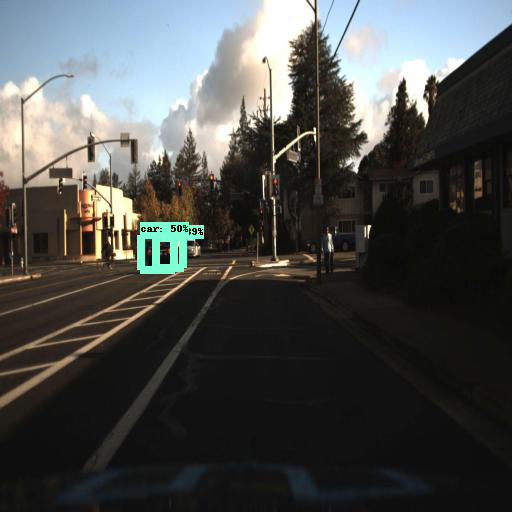

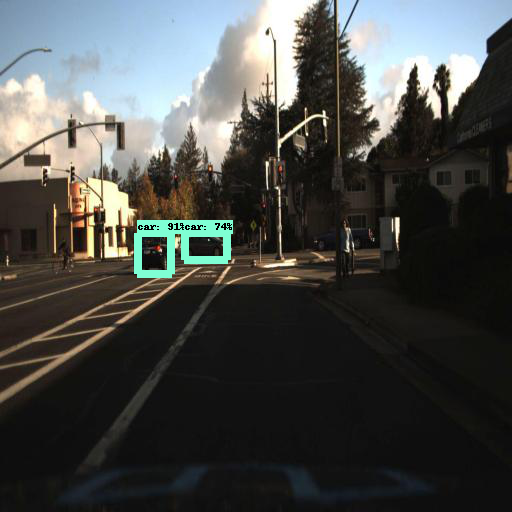

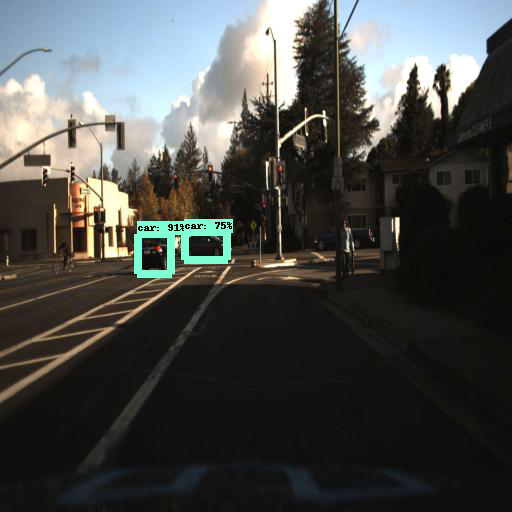

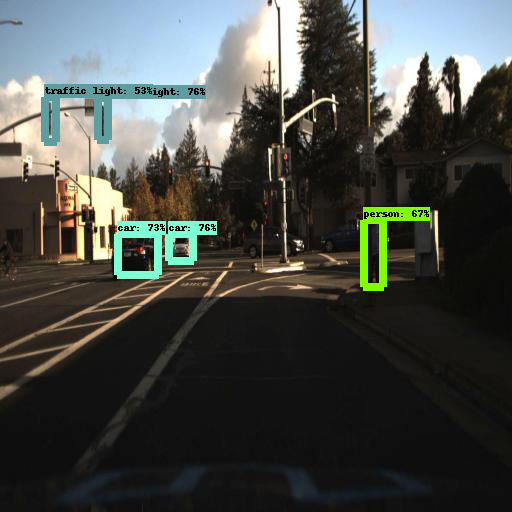

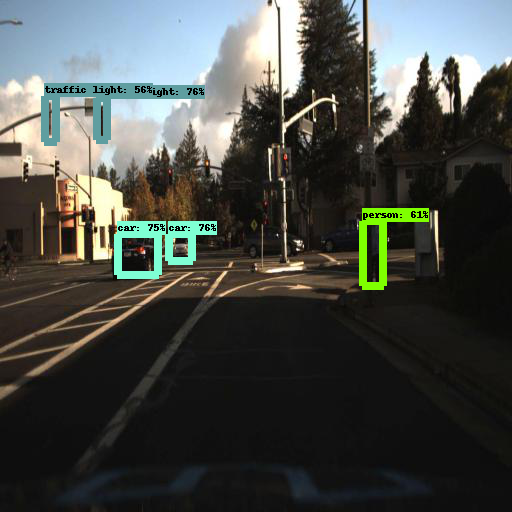

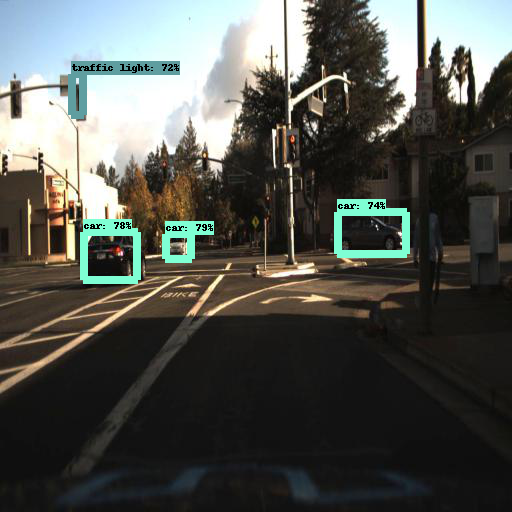

In [38]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(detection_model, image_path)